In [1]:
import sys
import os
Path = '/remote/tychodata/ftairli/work/Projects/Recurrent_Geometry_Reconstruction/Code/'
if Path not in sys.path:
    sys.path.append(Path)
    
import torch

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from Dataset import LSTMProcessingDatasetContainer, DatasetContainer
from TrainingModule import IterateInBatches

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
Name = 'Model_3_0_Recipient'
Model = torch.load(f'{Name}.pt')
Tracker = torch.load(f'{Name}_Tracker.pt')
print(Model.Description)
if 'Recipient' in Name and os.path.exists(f'{Name.replace("Recipient", "Donor")}_Tracker.pt'):
    TrackerDonor = torch.load(f'{Name.replace("Recipient", "Donor")}_Tracker.pt')
else:
    TrackerDonor = None


    Part of the Model_3_X series
    The Recipient Model (This one is trial, has no donor)

    Predict the difference between rec and truth data to improve the prediction
    


In [3]:
MinValLossEpoch = np.argmin(Tracker.EpochValLoss)
print(f'Min Val Loss Epoch: {MinValLossEpoch}')
# Model.load_state_dict(Tracker.ModelStates[MinValLossEpoch])

Min Val Loss Epoch: 7


In [4]:
print(f'Final Epoch          : {len(Tracker.EpochLoss)}')
print(f'Final Loss           : {Tracker.EpochLoss[-1]}')
print(f'Final Validation Loss: {Tracker.EpochValLoss[-1]}')

Final Epoch          : 23
Final Loss           : 0.008218615289660738
Final Validation Loss: 0.03360534831881523


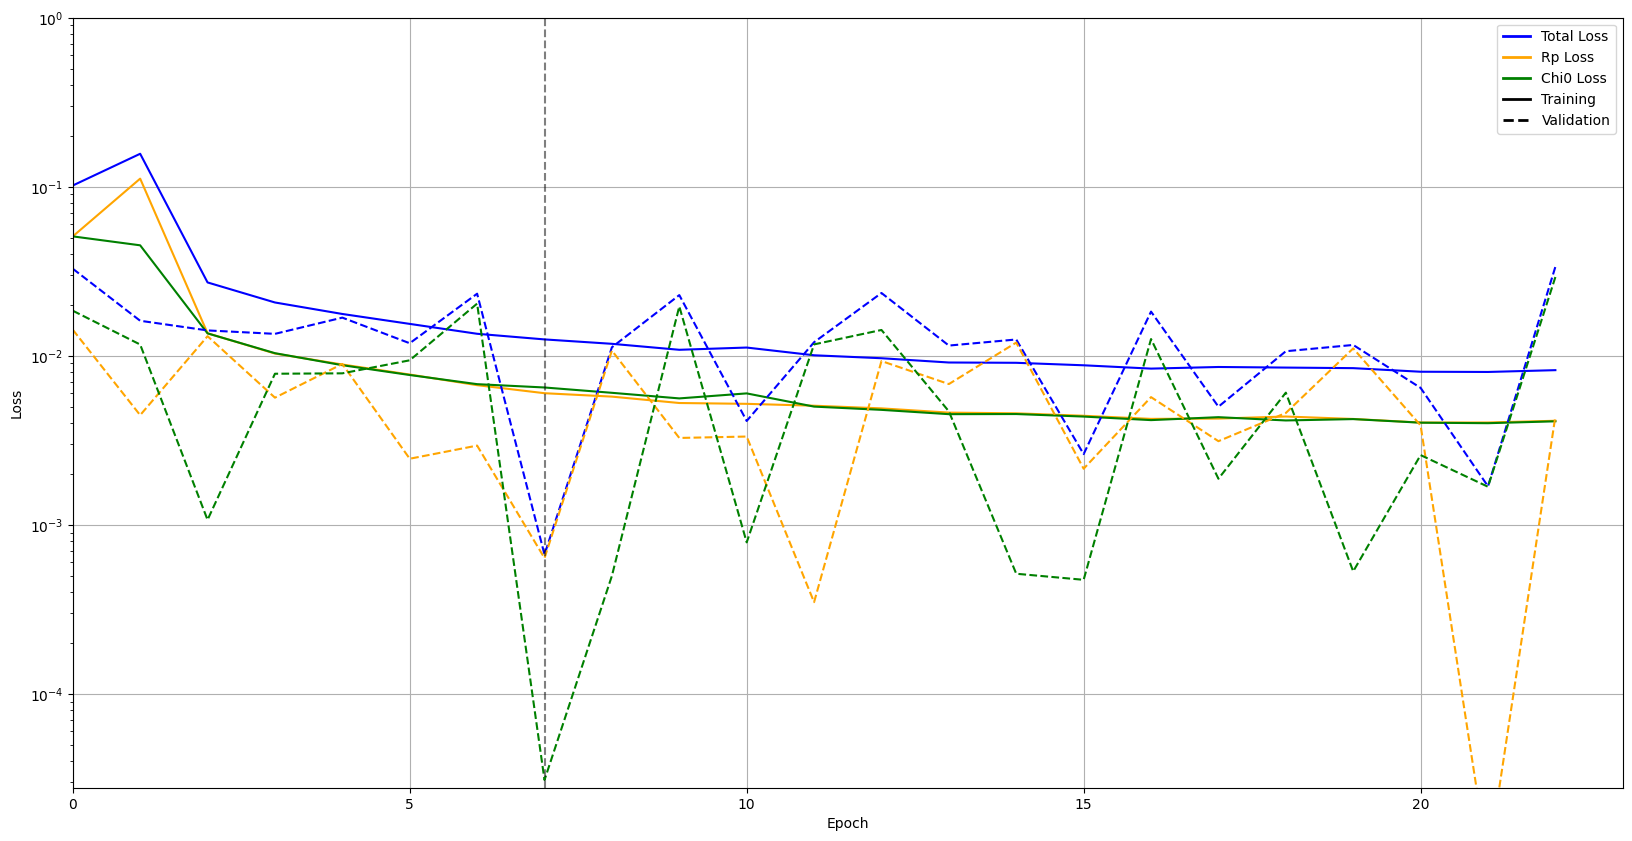

In [5]:
# Loss Plot
if TrackerDonor == None:
    Total_loss = Tracker.EpochLoss
    Rp_loss = Tracker.EpochLossRp
    Chi0_loss   = Tracker.EpochLossChi0

    Total_loss_val = Tracker.EpochValLoss
    Rp_loss_val = Tracker.EpochValLossRp
    Chi0_loss_val   = Tracker.EpochValLossChi0
else:
    Total_loss = TrackerDonor.EpochLoss + Tracker.EpochLoss
    Rp_loss = TrackerDonor.EpochLossRp + Tracker.EpochLossRp
    Chi0_loss   = TrackerDonor.EpochLossChi0 + Tracker.EpochLossChi0

    Total_loss_val = TrackerDonor.EpochValLoss + Tracker.EpochValLoss
    Rp_loss_val = TrackerDonor.EpochValLossRp + Tracker.EpochValLossRp
    Chi0_loss_val   = TrackerDonor.EpochValLossChi0 + Tracker.EpochValLossChi0

Nepochs = len(Total_loss)
plt.figure(figsize=(20, 10))

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan']

# Plot training loss
plt.plot(Total_loss , color=colors[0], label='Total Loss - Training')
plt.plot(Rp_loss    , color=colors[1], label='Rp Loss    - Training')
plt.plot(Chi0_loss  , color=colors[2], label='Chi0 Loss  - Training')

# # Plot validation loss
plt.plot(Total_loss_val , color=colors[0], linestyle='dashed', label='Total Loss  - Validation')
plt.plot(Rp_loss_val    , color=colors[1], linestyle='dashed', label='Rp Loss     - Validation')
plt.plot(Chi0_loss_val  , color=colors[2], linestyle='dashed', label='Chi0   Loss - Validation')

if TrackerDonor != None:
    plt.axvline(len(TrackerDonor.EpochLoss), color='black', linestyle='dashed',alpha = 0.5)
    plt.axvline(MinValLossEpoch+len(TrackerDonor.EpochLoss), color='black', linestyle='dashed',alpha = 0.5)
else:
    plt.axvline(MinValLossEpoch, color='black', linestyle='dashed',alpha = 0.5)
# Set up custom legend

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color='black'  , lw=2),
                Line2D([0], [0], color='black', linestyle='dashed', lw=2)]

plt.legend(custom_lines, ['Total Loss', 'Rp Loss', 'Chi0 Loss', 'Training', 'Validation'])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.9*min(Chi0_loss_val), 1)
plt.xlim(0, Nepochs)
plt.yscale('log')
plt.grid()
# plt.savefig(f'{Name}_Loss.png', dpi=300)


In [6]:
# Load Dataset
datapath = '/remote/tychodata/ftairli/work/Projects/Recurrent_Geometry_Reconstruction/Data/NormData/'
datapath_Raw = '/remote/tychodata/ftairli/work/Projects/Recurrent_Geometry_Reconstruction/Data/RawData/'
dataset = DatasetContainer(0)
dataset.Load(datapath_Raw, 'Run010')


ProcessingDataset = LSTMProcessingDatasetContainer()
ProcessingDataset.Load(datapath,'Run010')

from Training import GetTruths,GetRecTruths

ProcessingDataset.RandomIter = False # Need this to get the right order of inidices for the Rec Files


In [7]:
def UnnormaliseOutputs(Outputs):
    Chi0 = torch.acos(Outputs[:,0])
    Mean_Rp = 12800
    STD_Rp  = 5800
    Rp      = Outputs[:,1]*STD_Rp + Mean_Rp
    return torch.stack([Chi0, Rp], dim=1)
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [8]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RecTruths = GetRecTruths(dataset)

ProcessingDataset.State = 'Test'
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchTraces, BatchAux,BatchTruth in IterateInBatches(ProcessingDataset,256):
        Rec.append(RecTruths[EventIndex].to(device))
        BatchTraces      = BatchTraces     .to(device)
        BatchAux         = BatchAux        .to(device)[:,:3]
        BatchTruth       = BatchTruth      .to(device)
        
        Truth.append(BatchTruth)
        Pred.append(Model(BatchTraces, BatchAux))
        EvI+=1

Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = UnnormaliseOutputs(Truth)
Pred  = UnnormaliseOutputs(Pred)
Rec   = UnnormaliseOutputs(Rec)

Truth = Truth.cpu()
Pred  = Pred .cpu()
Rec   = Rec  .cpu()


# drop NaN values
if True:
    Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) & ~torch.isnan(Rec[:,0]) & ~torch.isnan(Rec[:,1])
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
    if True:
        Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
        print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
        Truth = Truth[Mask]
        Pred  = Pred [Mask]
        Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)



Pred Loss 0.005725401919335127
Rec  Loss 0.006530309095978737
Dropping 0 NaN values
 Nan Locations (tensor([], dtype=torch.int64),)
Dropping 48 Bad events
(18384, 2)
(18384, 2)


In [12]:
# # # Compute the Test Set with  Event Length
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# RecTruths = GetRecTruths(dataset)

# ProcessingDataset.State = 'Test'
# Truth = []
# Pred  = []
# Rec   = []
# EventDuration = []
# EventLength   = []
# Model.eval()
# EvI = 0
# with torch.no_grad():
#     for EventIndex,BatchTraces,BatchAux,BatchTruth in IterateInBatches(ProcessingDataset,1):
#         print(f'Event {EvI}',end='\r')

#         BatchTraces      = BatchTraces     .to(device)
#         BatchAux         = BatchAux        .to(device)
#         BatchTruth       = BatchTruth      .to(device)
        
        
#         Truth.append(BatchTruth)
#         Pred.append(Model(BatchTraces, BatchAux))
#         Rec.append(RecTruths[EventIndex])
#         EventDuration.append(1000-torch.sum(BatchTraces[0,:,0]==-1))
#         EventLength.append(torch.max(BatchTraces[0,:,1])-torch.min(BatchTraces[0,:,1][BatchTraces[0,:,1]>0]))

#         EvI+=1


# Truth = torch.cat(Truth, dim=0)
# Pred  = torch.cat(Pred , dim=0)
# Rec   = torch.cat(Rec  , dim=0)
# EventDuration = torch.tensor(EventDuration)
# EventLength = torch.tensor(EventLength)

# Truth = UnnormaliseOutputs(Truth)
# Pred  = UnnormaliseOutputs(Pred)
# Rec   = UnnormaliseOutputs(Rec)


# Truth = Truth.cpu()
# Pred  = Pred .cpu()
# Rec   = Rec  .cpu()
# EventDuration = EventDuration.cpu()
# EventLength = EventLength.cpu()


# # drop NaN values
# if True:
#     Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) & ~torch.isnan(Rec[:,0]) & ~torch.isnan(Rec[:,1])
#     print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
#     Truth = Truth[Mask]
#     Pred  = Pred [Mask]
#     Rec   = Rec  [Mask]
#     EventDuration = EventDuration[Mask]
#     EventLength = EventLength[Mask]

# Truth = Truth.numpy()
# Pred  = Pred .numpy()
# Rec   = Rec  .numpy()
# EventDuration = EventDuration.numpy()
# EventLength = EventLength.numpy()


In [9]:
# Chi0_Pred_MSE = MeanSquaredError(Truth[:,0],Pred[:,0])
# Rp_Pred_MSE   = MeanSquaredError(Truth[:,1],Pred[:,1])

# Chi0_Rec_MSE = MeanSquaredError(Truth[:,0],Rec[:,0])
# Rp_Rec_MSE   = MeanSquaredError(Truth[:,1],Rec[:,1])

# print(f'Mean Squared Error Chi0_Pred   : {Chi0_Pred_MSE}')
# print(f'Mean Squared Error Chi0_Rec    : {Chi0_Rec_MSE}')
# print()
# print(f'Mean Squared Error Rp_Pred     : {Rp_Pred_MSE}')
# print(f'Mean Squared Error Rp_Rec      : {Rp_Rec_MSE}')
# print()
# print(f'Ratio Mean Squared Error Chi0 : {Chi0_Pred_MSE/Chi0_Rec_MSE}')
# print(f'Ratio Mean Squared Error Rp   : {Rp_Pred_MSE/Rp_Rec_MSE}')
# print('_____________________________________________________')
# print()

# 68th percentile
Chi0_Pred_P68 = Percentile68(Truth[:,0],Pred[:,0])
Rp_Pred_P68   = Percentile68(Truth[:,1],Pred[:,1])

Chi0_Rec_P68 = Percentile68(Truth[:,0],Rec[:,0])#+0.2/180*np.pi)
Rp_Rec_P68   = Percentile68(Truth[:,1],Rec[:,1])

print(f'68% Chi0_Pred   : {Chi0_Pred_P68/np.pi*180:.5} deg ')
print(f'68% Chi0_Rec    : {Chi0_Rec_P68 /np.pi*180:.5} deg')
print()
print(f'68% Rp_Pred     : {Rp_Pred_P68:.5} m')
print(f'68% Rp_Rec      : {Rp_Rec_P68 :.5} m')
print()
print(f'68% Ratio Chi0  : {Chi0_Pred_P68/Chi0_Rec_P68:.5}')
print(f'68% Ratio Rp    : {Rp_Pred_P68/Rp_Rec_P68:.5}')
print()

# print(f'Adjusted Percentile for Rec Chi0 {Percentile68(Truth[:,0],Rec[:,0]-np.mean(Truth[:,0]-Rec[:,0])):.5}')
# print(f'Adjusted Precentile for Rec Rp   {Percentile68(Truth[:,1],Rec[:,1]-np.mean(Truth[:,1]-Rec[:,1])):.5}')

68% Chi0_Pred   : 2.5184 deg 
68% Chi0_Rec    : 0.40123 deg

68% Rp_Pred     : 537.61 m
68% Rp_Rec      : 37.629 m

68% Ratio Chi0  : 6.2767
68% Ratio Rp    : 14.287



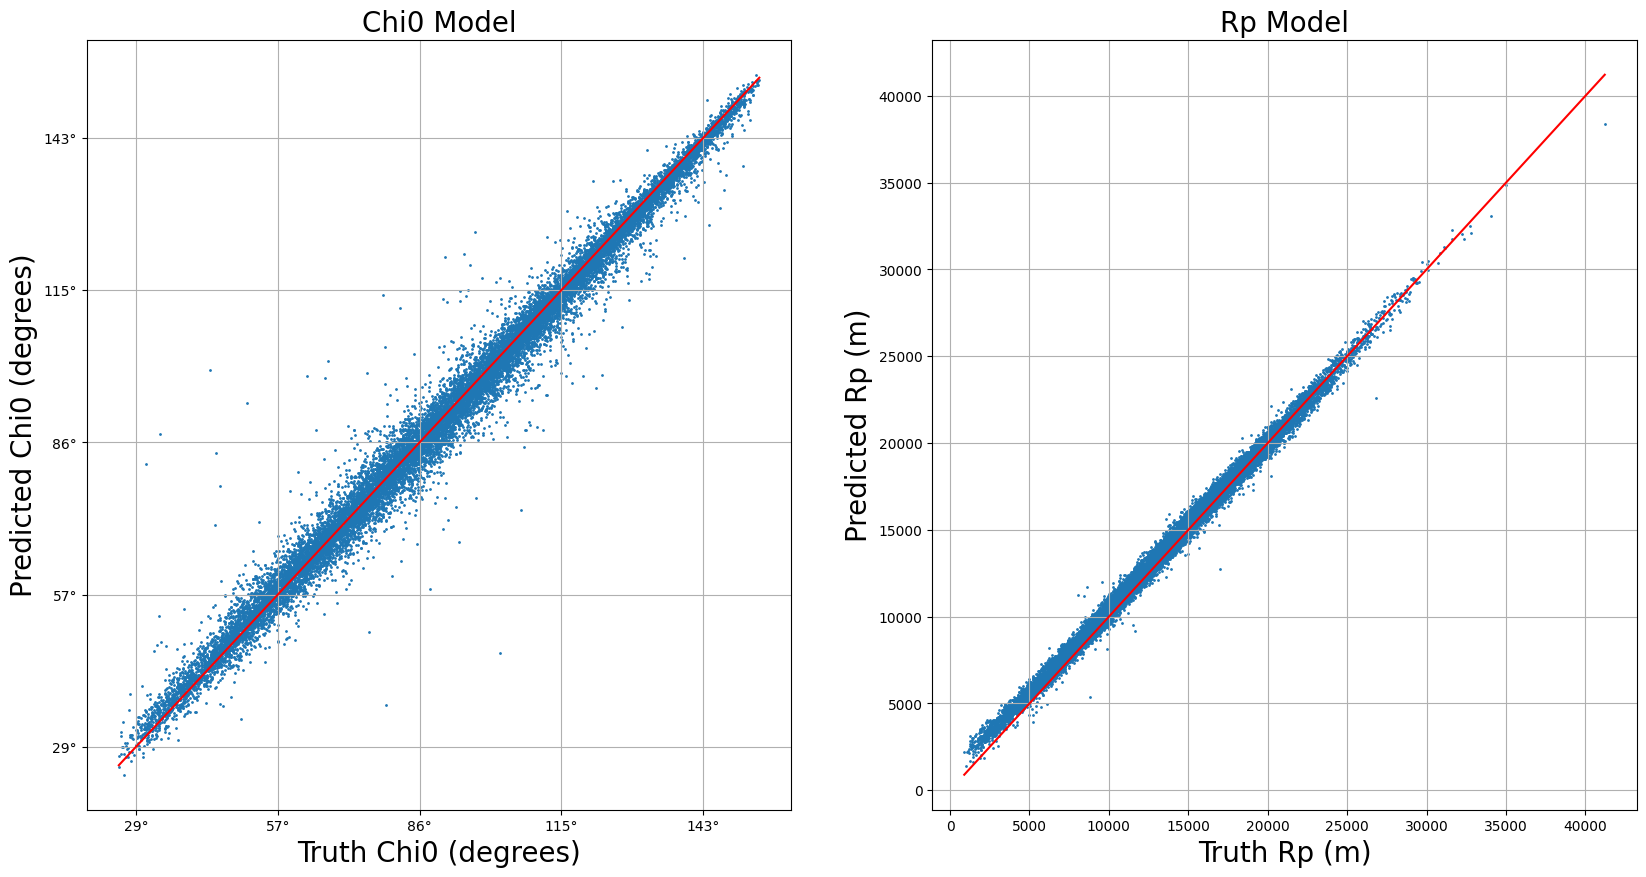

In [10]:
# Easy Scatter Plots of Truth vs Predicted
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(Truth[:, 0], Pred[:, 0], s=1)
ax[0].plot([min(Truth[:, 0]), max(Truth[:, 0])], [min(Truth[:, 0]), max(Truth[:, 0])], 'r')
ax[0].set_xlabel('Truth Chi0 (degrees)',fontsize=20)
ax[0].set_ylabel('Predicted Chi0 (degrees)',fontsize=20)
ax[0].set_title('Chi0 Model',fontsize=20)

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
ax[0].grid()

# Scatter plot for the second subplot
ax[1].scatter(Truth[:, 1], Pred[:, 1], s=1)
ax[1].plot([min(Truth[:, 1]), max(Truth[:, 1])], [min(Truth[:, 1]), max(Truth[:, 1])], 'r')
ax[1].set_xlabel('Truth Rp (m)',fontsize=20)
ax[1].set_ylabel('Predicted Rp (m)',fontsize=20)
ax[1].set_title('Rp Model',fontsize=20)

ax[1].grid()
# plt.savefig(f'../Results/')

plt.show()


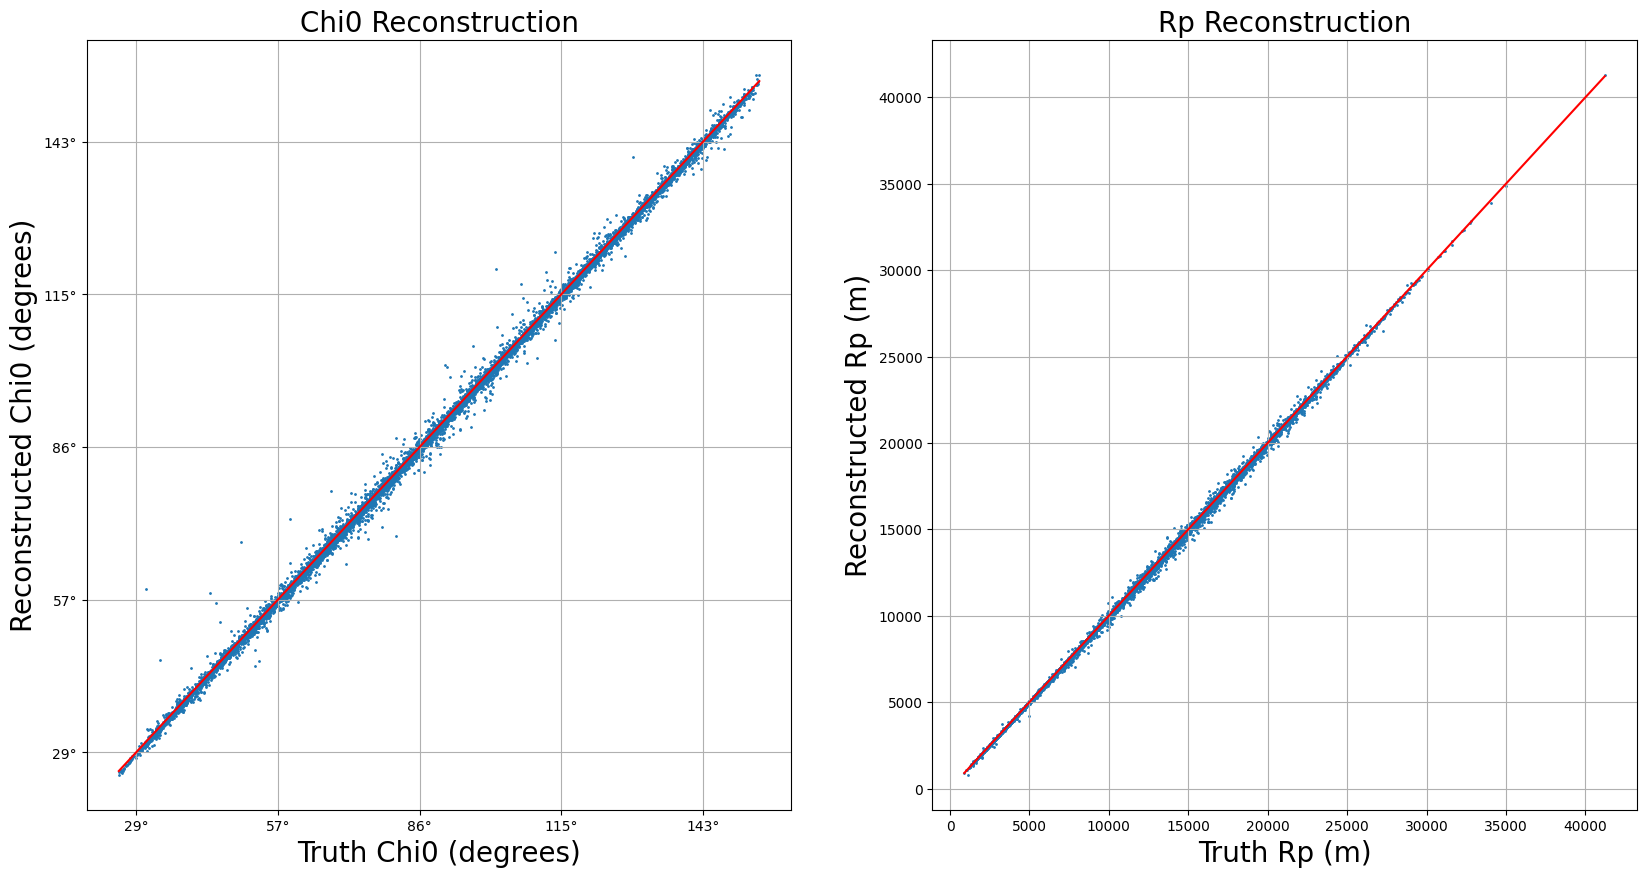

In [11]:
# Easy Scatter Plots of Truth vs Reconstruction
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Scatter plot for the first subplot
ax[0].scatter(Truth[:, 0], Rec[:, 0], s=1)
ax[0].plot([min(Truth[:, 0]), max(Truth[:, 0])], [min(Truth[:, 0]), max(Truth[:, 0])], 'r')
ax[0].set_xlabel('Truth Chi0 (degrees)',fontsize=20)
ax[0].set_ylabel('Reconstructed Chi0 (degrees)',fontsize=20)
ax[0].set_title('Chi0 Reconstruction',fontsize=20)

# Set x and y ticks for the first subplot
xticks = ax[0].get_xticks()
ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
yticks = ax[0].get_yticks()
ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
ax[0].grid()

# Scatter plot for the second subplot
ax[1].scatter(Truth[:, 1], Rec[:, 1], s=1)
ax[1].plot([min(Truth[:, 1]), max(Truth[:, 1])], [min(Truth[:, 1]), max(Truth[:, 1])], 'r')
ax[1].set_xlabel('Truth Rp (m)',fontsize=20)
ax[1].set_ylabel('Reconstructed Rp (m)',fontsize=20)
ax[1].set_title('Rp Reconstruction',fontsize=20)

ax[1].grid()
# plt.savefig(f'../Results/')

plt.show()


In [12]:
# Deviation plots
import seaborn as sns

def PlotDeviation(Truth,Pred,Name,Binrange = [[[0.4,np.pi-0.4],[-0.07,0.07]],[[0,30000],[-500,500]]],pthresh = 0.01):
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))

    # Scatter plot for the first subplot
    X = Truth[:, 0]
    Y = Pred[:, 0] - Truth[:, 0]

    # sns.scatterplot(x=X, y=Y, ax=ax[0], s=5,color='.15')
    sns.histplot(x=X, y=Y, ax=ax[0], bins=100, pthresh=pthresh,cmap = 'mako',cbar = True,binrange = Binrange[0],kde=True)
    ax[0].set_xlabel('True Cih0 (degrees)') 
    ax[0].set_ylabel('Angular Deviation (degrees)')
    ax[0].set_title(f'Chi0 {Name} Deviation')
    ax[0].axhline(0, color='red', lw=2)
    ax[0].set_ylim(Binrange[0][1])
    ax[0].grid()

    # Set x and y ticks for the first subplot
    xticks = ax[0].get_xticks()
    ax[0].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
    yticks = ax[0].get_yticks()
    ax[0].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])




    X = Truth[:, 1]
    Y = Pred[:, 1] - Truth[:, 1]

    # sns.scatterplot(x=X, y=Y, ax=ax[1], s=5,color='.15')
    sns.histplot(x=X, y=Y, ax=ax[1], bins=100, pthresh=pthresh,cmap = 'mako',cbar = True,binrange = Binrange[1])
    ax[1].set_xlabel('True Rp (m)')
    ax[1].set_ylabel('Radial Deviation (m)')
    ax[1].set_title(f'Rp {Name} Deviation')
    ax[1].axhline(0, color='red', lw=2)
    ax[1].set_ylim(Binrange[1][1])
    ax[1].set_xlim(0,30000)
    ax[1].grid()

    plt.show()

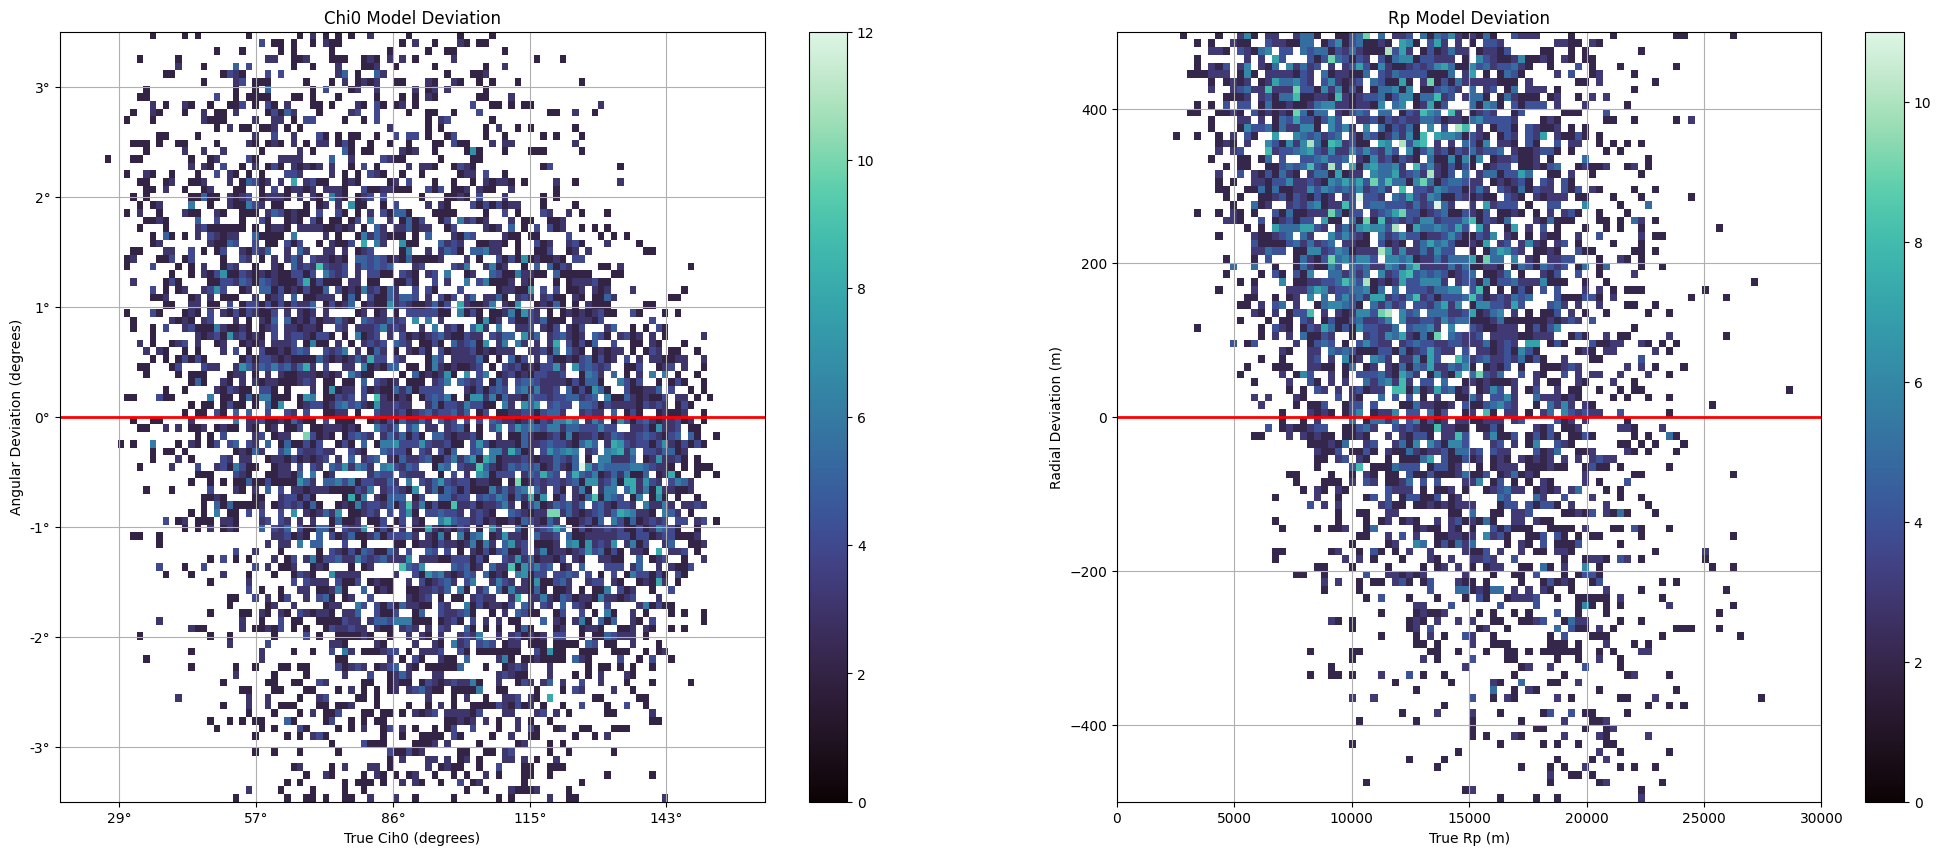

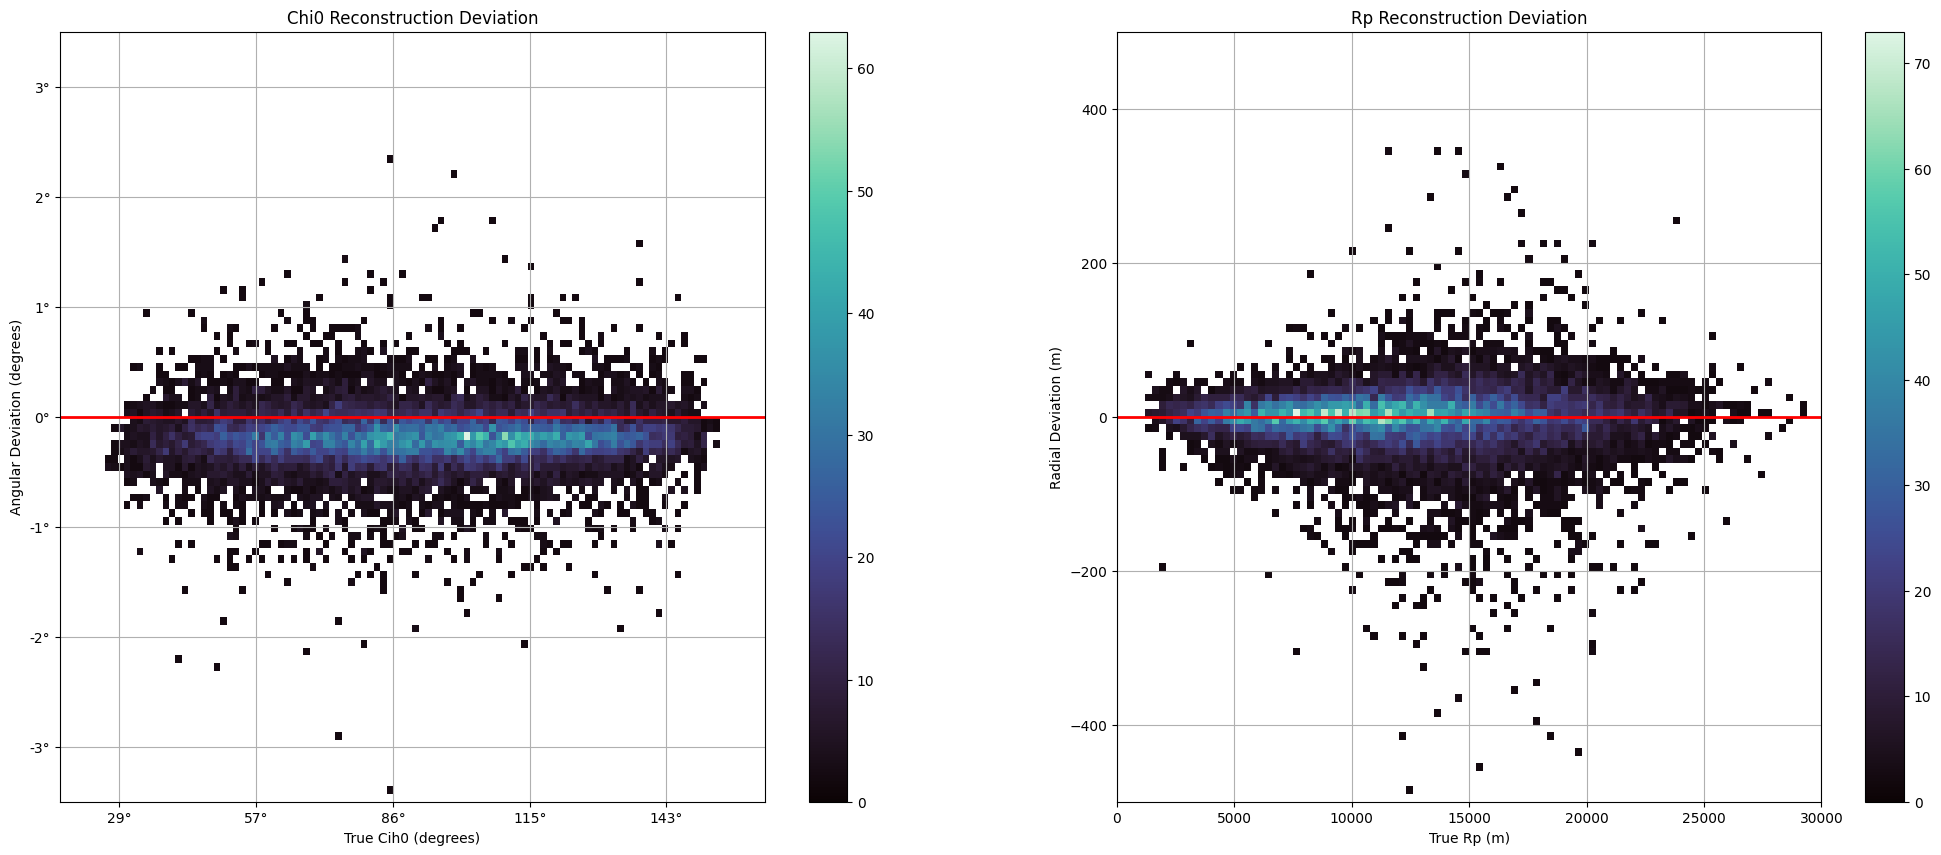

In [13]:
PlotDeviation(Truth,Pred,'Model')
PlotDeviation(Truth,Rec,'Reconstruction')

In [18]:
# Print average deviation for Chi0 and Rp
print(f'Mean Deviation for Rec Chi0 = {np.median(Rec[:,0]-Truth[:,0])*180/np.pi}')
print(f'Mean Deviation for Rec Rp   = {np.median(Rec[:,1]-Truth[:,1])}')

Mean Deviation for Rec Chi0 = -0.22431024253238876
Mean Deviation for Rec Rp   = -0.4814453125
